# 1. Estimation of Obesity Levels - Female only

A variation of the Estimation of Obesity script using only the most-relevant features for classifying Female records only.

## 1. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time

from collections import Counter
from scipy.stats import ttest_ind, f_oneway
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
# Start script run time
script_start_time = time.time()

In [3]:
def run_time(start_time):
  """
  Calculate run time (hours, minutes, seconds)
  start_time - Start time of script/model
  """

  # End time
  end_time = time.time()

  # Compute run time (hours, minutes, seconds)
  hours = int((end_time - start_time) / 3600)
  minutes = int(((end_time - start_time) % 3600) / 60)
  seconds = int(((end_time - start_time) % 3600) % 60)

  return hours, minutes, seconds

## 2. Data Preprocessing

### 2.1. Load Data

In [4]:
try:
  # Load dataframe (df) into appropriate format
  dataset = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
  print("Data loaded successfully.")
except:
  # No data found
  print("Data not found. Please try again.")
  sys.exit()

Data loaded successfully.


### 2.2. Inital Preprocessing

In [5]:
# Restrict data to Male records only
dataset = dataset[dataset['Gender'] == 'Female']

# Drop gender column
dataset = dataset.drop(columns=['Gender'])

In [6]:
dataset

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
6,23.000000,1.500000,55.000000,yes,yes,3.0,3.0,Sometimes,no,2.000000,no,1.000000,0.000000,Sometimes,Motorbike,Normal_Weight
11,21.000000,1.720000,80.000000,yes,yes,2.0,3.0,Frequently,no,2.000000,yes,2.000000,1.000000,Sometimes,Public_Transportation,Overweight_Level_II
15,22.000000,1.700000,66.000000,yes,no,3.0,3.0,Always,no,2.000000,yes,2.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [7]:
# Brief info about dataframe - non-null values and datatype
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1043 entries, 0 to 2110
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             1043 non-null   float64
 1   Height                          1043 non-null   float64
 2   Weight                          1043 non-null   float64
 3   family_history_with_overweight  1043 non-null   object 
 4   FAVC                            1043 non-null   object 
 5   FCVC                            1043 non-null   float64
 6   NCP                             1043 non-null   float64
 7   CAEC                            1043 non-null   object 
 8   SMOKE                           1043 non-null   object 
 9   CH2O                            1043 non-null   float64
 10  SCC                             1043 non-null   object 
 11  FAF                             1043 non-null   float64
 12  TUE                             1043 no

In [8]:
# Check for duplicate records
dataset.duplicated().sum()

np.int64(8)

In [9]:
# Check for missing values
dataset.isnull().sum()

,0
Age,0
Height,0
Weight,0
family_history_with_overweight,0
FAVC,0
FCVC,0
NCP,0
CAEC,0
SMOKE,0
CH2O,0


In [10]:
# # -- Drop/impute missing data (if required) --

# # Drop rows with missing values
# dataset = dataset.dropna(axis=0, how='any')

# # ['mean', 'median', 'most_frequent', 'constant']
# imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
# imputer.fit_transform(dataset)
# dataset = imputer.transform(dataset)

# dataset.isnull().sum()

In [11]:
# Re-organize dataframe
dataset = dataset[['Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS',
       'NObeyesdad']]

In [12]:
# Dataframe statistics on quantitative (numerical) values
dataset.describe(include='all')

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
count,1043.000000,1043.000000,1043.000000,1043,1043,1043.000000,1043.000000,1043,1043,1043.000000,1043,1043.000000,1043.000000,1043,1043,1043
unique,NaN,NaN,NaN,2,2,NaN,NaN,4,2,NaN,2,NaN,NaN,3,4,7
top,NaN,NaN,NaN,yes,yes,NaN,NaN,Sometimes,no,NaN,no,NaN,NaN,Sometimes,Public_Transportation,Obesity_Type_III
freq,NaN,NaN,NaN,811,900,NaN,NaN,844,1028,NaN,973,NaN,NaN,711,854,323
mean,24.001907,1.643298,82.302364,NaN,NaN,2.567319,2.632419,NaN,NaN,1.941083,NaN,0.847137,0.647227,NaN,NaN,NaN
std,6.407832,0.074509,29.723904,NaN,NaN,0.548079,0.816352,NaN,NaN,0.634037,NaN,0.840443,0.572016,NaN,NaN,NaN
min,15.000000,1.450000,39.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,19.627721,1.596526,58.000000,NaN,NaN,2.000000,2.663175,NaN,NaN,1.383862,NaN,0.000000,0.000000,NaN,NaN,NaN
50%,22.000000,1.639524,78.000000,NaN,NaN,2.964419,3.000000,NaN,NaN,2.000000,NaN,0.742113,0.655558,NaN,NaN,NaN
75%,26.000000,1.699516,105.036863,NaN,NaN,3.000000,3.000000,NaN,NaN,2.485002,NaN,1.507336,1.000000,NaN,NaN,NaN


## 3. Initial Exploratory Data Analysis (EDA)

In [13]:
# Significance value (alpha) for hypothesis testing
alpha = 0.05

In [14]:
def t_test(a, b, alpha=0.05):
  """
  Perform a two-sample Student's t-Test for Groups a and b
  a     - Group a
  b     - Group b
  alpha - Significance level (e.g: 0.05 -> 0.95 or 95% confidence level)
  """

  # Perform a two-sample t-test
  stat, p = ttest_ind(a, b, equal_var=False, alternative='two-sided')
  print('t-value=%.3f, p-value=%.3f, significance level=%.2f' % (stat, p, alpha))
  # Interpret results
  if (p < alpha):
      print('Reject Null Hypothesis (H0)')
  else:
      print('Fail to Reject Null Hypothesis (H0)')


#### Pairwise relationships between features - Numerical data

<Figure size 300x300 with 0 Axes>

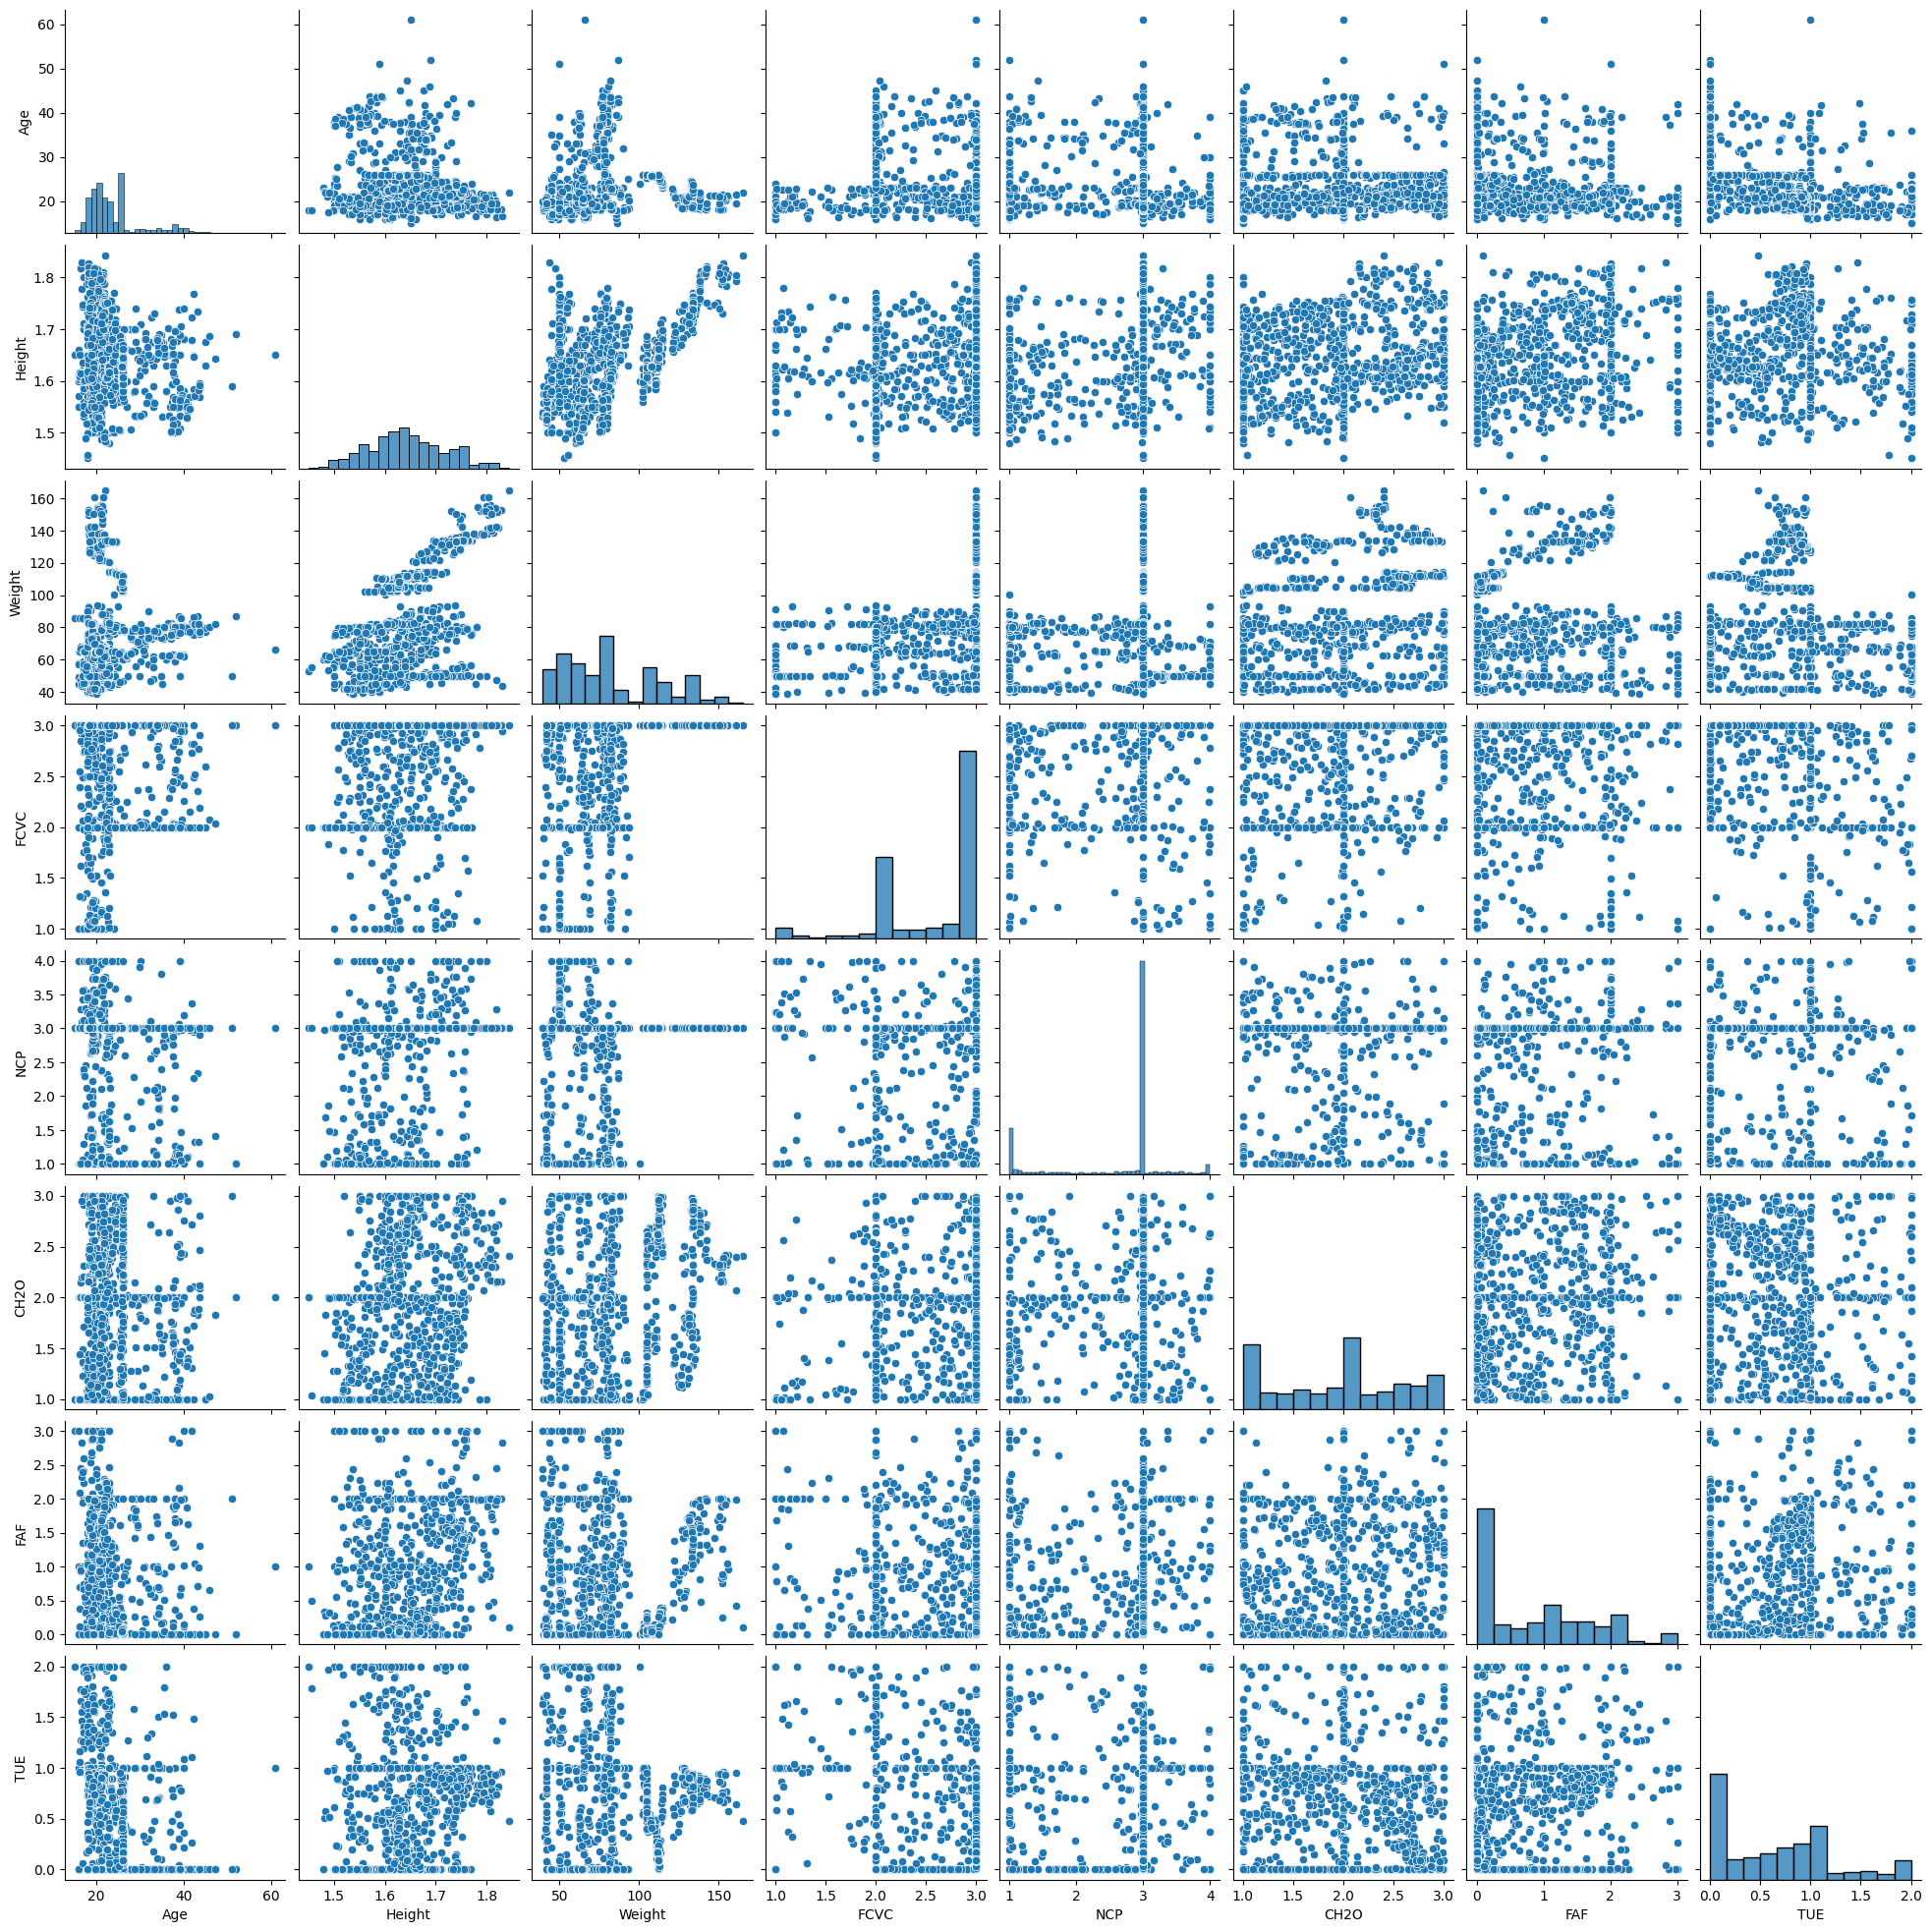

In [15]:
# Define pairplot
plt.figure(figsize=(3,3))

# Pairwise distributions
sns.pairplot(dataset)

# Show figure
plt.show()

#### Correlation Map - Numerical data

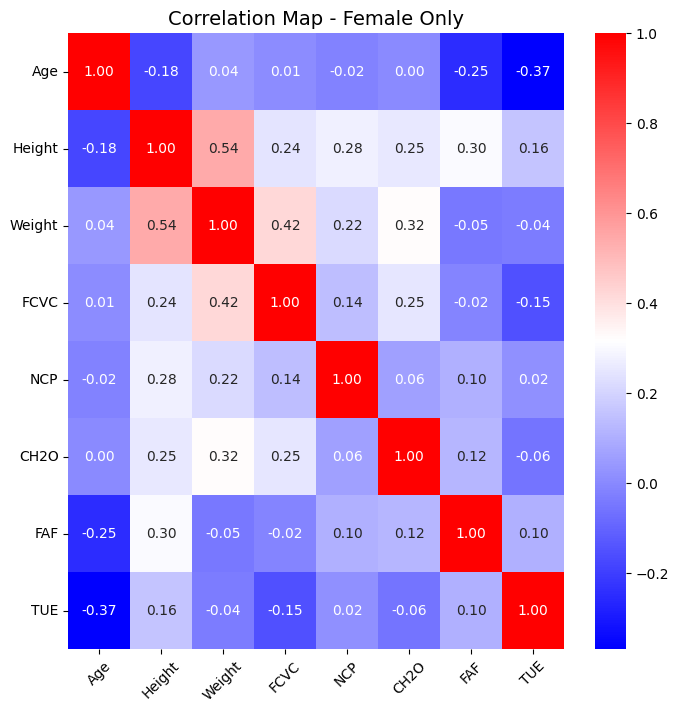

In [16]:
# Define correlation map figure
plt.figure(figsize=(8,8))

# Correlation Map
sns.heatmap(dataset[['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']].corr(),
            cmap='bwr', annot=True, fmt = ".2f")
# Adjust X and Y-Axes
plt.xticks(rotation=45)
plt.yticks(rotation=0)
# Plot title
plt.title('Correlation Map - Female Only', fontsize=14)

# Show figure
plt.show()

#### Height distribution

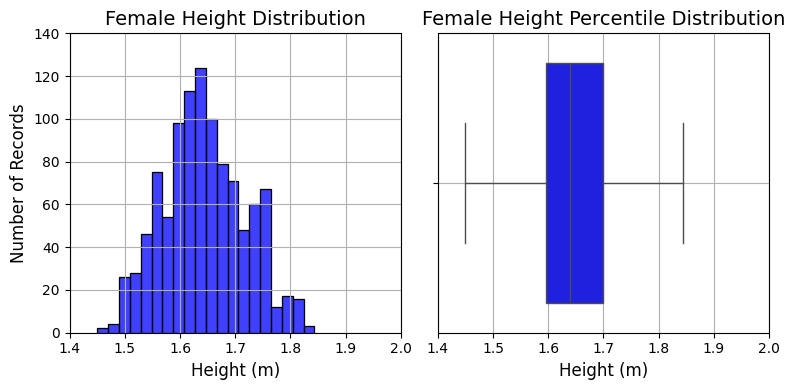

In [17]:
# Define subplot figure
height_dist_1 = plt.figure(figsize=(8,4))

# Histogram - Male Height
ax1 = height_dist_1.add_subplot(1, 2, 1)
ax1 = sns.histplot(data=dataset, x='Height', bins=20, color='blue')
# Adjust axes range(s)
plt.xticks(np.arange(1.4, 2.0, 0.1))
plt.yticks(np.arange(0, 160, 20))
# Plot title and label(s)
plt.title('Female Height Distribution', fontsize=14)
plt.xlabel('Height (m)', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot grid
plt.grid(True)

# Box plot - Male Height
ax2 = height_dist_1.add_subplot(1, 2, 2)
ax2 = sns.boxplot(data=dataset, x='Height', color='blue')
# Adjust axes range(s)
plt.xticks(np.arange(1.4, 2.0, 0.1))
# Plot title and label(s)
plt.title('Female Height Percentile Distribution', fontsize=14)
plt.xlabel('Height (m)', fontsize=12)
# Plot grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

#### Weight distribution

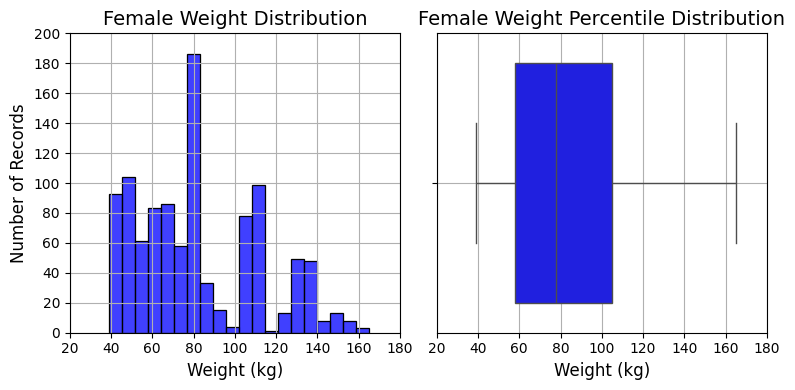

In [18]:
# Define subplot figure
weight_dist_1 = plt.figure(figsize=(8,4))

# Histogram - Male Weight
ax1 = weight_dist_1.add_subplot(1, 2, 1)
ax1 = sns.histplot(data=dataset, x='Weight', bins=20, color='blue')
# Adjust axes range(s)
plt.xticks(np.arange(20, 200, 20))
plt.yticks(np.arange(0, 220, 20))
# Plot title and label(s)
plt.title('Female Weight Distribution', fontsize=14)
plt.xlabel('Weight (kg)', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot grid
plt.grid(True)

# Box plot - Male Weight
ax2 = weight_dist_1.add_subplot(1, 2, 2)
ax2 = sns.boxplot(data=dataset, x='Weight', color='blue')
# Adjust axes range(s)
plt.xticks(np.arange(20, 200, 20))
# Plot title and label(s)
plt.title('Female Weight Percentile Distribution', fontsize=14)
plt.xlabel('Weight (kg)', fontsize=12)
# Plot grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

#### Has a family member suffered or suffers from overweight?

/tmp/ipython-input-1909900048.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  overweight_hist_1 = sns.countplot(data=dataset, x='family_history_with_overweight',


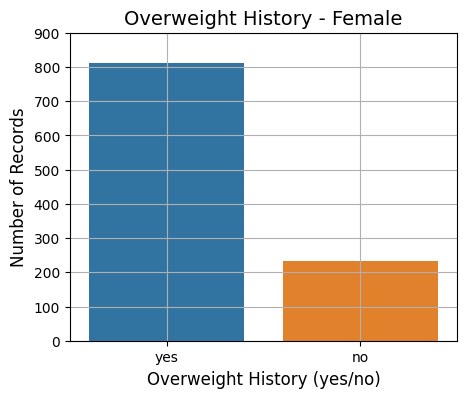

In [19]:
# Define subplot figure
overweight_hist_1 = plt.figure(figsize=(5, 4))

# Overweight History
overweight_hist_1 = sns.countplot(data=dataset, x='family_history_with_overweight',
                                  palette='tab10')
# Adjust Y-Axis axes range(s)
plt.yticks(np.arange(0, 1000, 100))
# Plot title and label(s)
plt.title('Overweight History - Female', fontsize=14)
plt.xlabel('Overweight History (yes/no)', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot legend and grid
plt.grid(True)

# Show figure
plt.show()

#### Do you eat high caloric food frequently?

/tmp/ipython-input-1503421564.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  high_cal_foods_1 = sns.countplot(data=dataset, x='FAVC', palette='tab10')


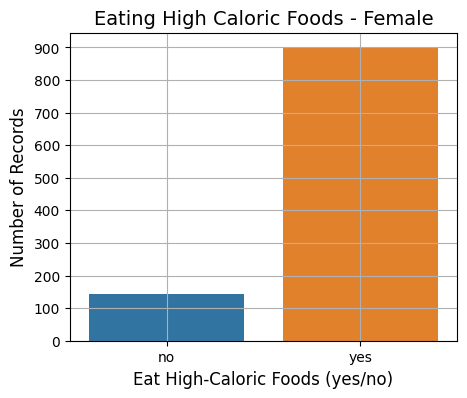

In [20]:
# Define subplot figure
high_cal_foods_1 = plt.figure(figsize=(5,4))

# Eating high-caloric foods
high_cal_foods_1 = sns.countplot(data=dataset, x='FAVC', palette='tab10')
# Adjust Y-Axis axes range(s)
plt.yticks(np.arange(0, 1000, 100))
# Plot title and label(s)
plt.title('Eating High Caloric Foods - Female', fontsize=14)
plt.xlabel('Eat High-Caloric Foods (yes/no)', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot legend and grid
plt.grid(True)

# Show figure
plt.show()

#### Do you usually eat vegetables in your meals?

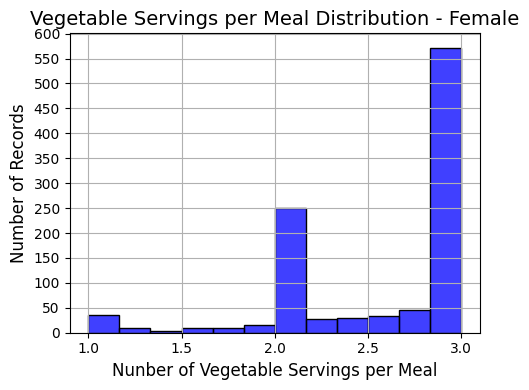

In [21]:
# Define subplot figure
eat_veggies_1 = plt.figure(figsize=(5,4))

# Vegetable Servings
sns.histplot(data=dataset, x='FCVC', color='blue')
# Adjust axes range(s)
plt.xticks(np.arange(1, 3.5, 0.5))
plt.yticks(np.arange(0, 650, 50))
# Plot title and label(s)
plt.title('Vegetable Servings per Meal Distribution - Female', fontsize=14)
plt.xlabel('Nunber of Vegetable Servings per Meal', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

#### Do you eat any food between meals?

/tmp/ipython-input-254393239.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  food_bw_meals_1 = sns.countplot(data=dataset, x='CAEC', palette='tab10')


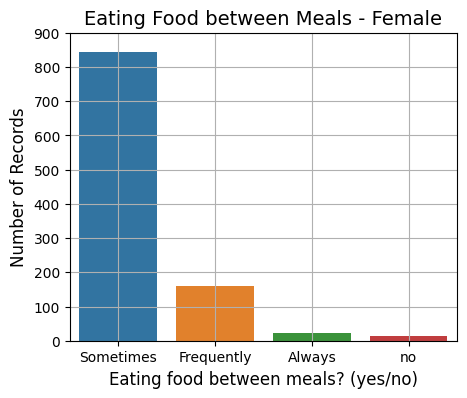

In [22]:
# Define subplot figure
food_bw_meals_1 = plt.figure(figsize=(5,4))

# Food between meals?
food_bw_meals_1 = sns.countplot(data=dataset, x='CAEC', palette='tab10')
# Adjust Y-Axis axes range(s)
plt.yticks(np.arange(0, 1000, 100))
# Plot title and label(s)
plt.title('Eating Food between Meals - Female', fontsize=14)
plt.xlabel('Eating food between meals? (yes/no)', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot legend and grid
plt.grid(True)

# Show figure
plt.show()

#### How often do you drink alcohol?

/tmp/ipython-input-3611448366.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  alcohol_1 = sns.countplot(data=dataset, x='CALC', palette='tab10')


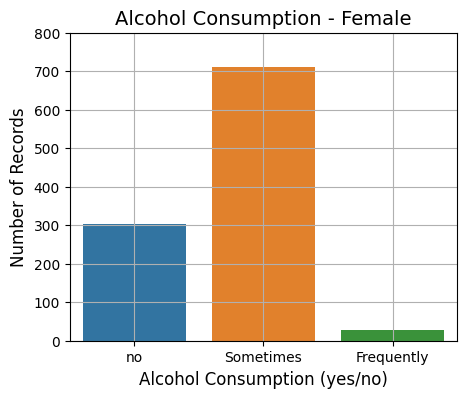

In [23]:
# Define subplot figure
alcohol_1 = plt.figure(figsize=(5,4))

# Alcohol Consumption
alcohol_1 = sns.countplot(data=dataset, x='CALC', palette='tab10')
# Adjust Y-Axis axes range(s)
plt.yticks(np.arange(0, 900, 100))
# Plot title and label(s)
plt.title('Alcohol Consumption - Female', fontsize=14)
plt.xlabel('Alcohol Consumption (yes/no)', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot legend and grid
plt.grid(True)

# Show figure
plt.show()

#### Which transportation do you usually use?

/tmp/ipython-input-2855789399.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  transit_hist_1 = sns.countplot(data=dataset, x='MTRANS', palette='tab10')


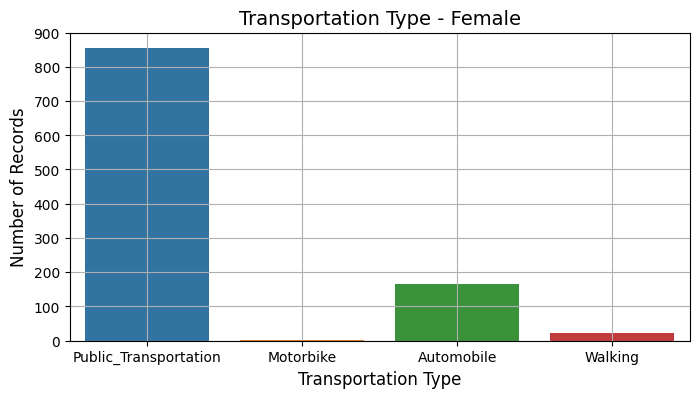

In [24]:
# Define figure
transit_hist_1 = plt.figure(figsize=(8, 4))

# Transportation Type - Female
transit_hist_1 = sns.countplot(data=dataset, x='MTRANS', palette='tab10')
# Adjust Y-Axis axes range(s)
plt.yticks(np.arange(0, 1000, 100))
# Plot title and label(s)
plt.title('Transportation Type - Female', fontsize=14)
plt.xlabel('Transportation Type', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot legend and grid
plt.grid(True)

# Show figure
plt.show()

/tmp/ipython-input-3662589770.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  transit_gender_1 = sns.violinplot(data=dataset, x='MTRANS', y='Age', palette='tab10')


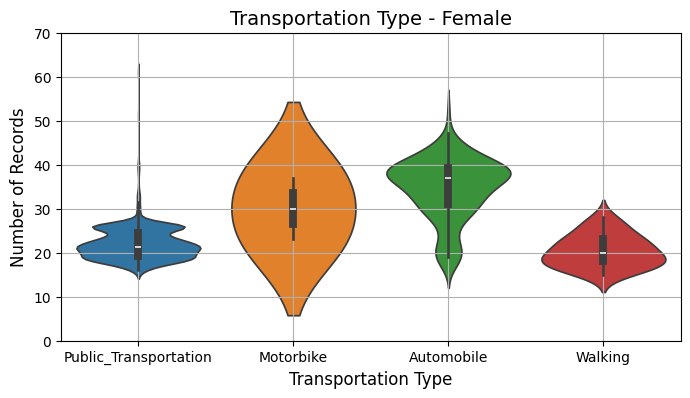

In [25]:
# Define subplot figure
transit_gender_1 = plt.figure(figsize=(8, 4))

# Transportation Type - Female - violin plot
transit_gender_1 = sns.violinplot(data=dataset, x='MTRANS', y='Age', palette='tab10')
# Adjust Y-Axis axes range(s)
plt.yticks(np.arange(0, 80, 10))
# Plot title and label(s)
plt.title('Transportation Type - Female', fontsize=14)
plt.xlabel('Transportation Type', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot legend and grid
plt.grid(True)

# Show figure
plt.show()

*No female records indicating using bikes as their main mode of transportation.

#### Obesity Level (dependent variable)

In [26]:
obesity_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
                 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II',
                 'Obesity_Type_III']

/tmp/ipython-input-3817066430.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  obesity_level_dist = sns.countplot(data=dataset, x='NObeyesdad', palette='tab10',


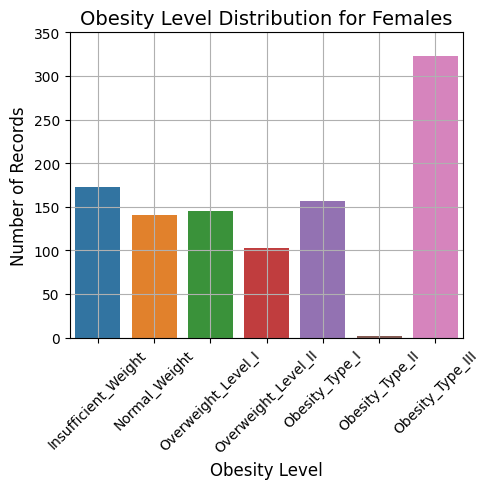

In [27]:
# Define figure
obesity_level_dist = plt.figure(figsize=(5,5))

# Obesity Level - Male
obesity_level_dist = sns.countplot(data=dataset, x='NObeyesdad', palette='tab10',
                                   order=obesity_order, dodge=False)

# Adjust X and Y-Axes
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 400, 50))
# Plot title and axes labels
plt.title('Obesity Level Distribution for Females', fontsize=14)
plt.xlabel('Obesity Level', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot legend and grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

/tmp/ipython-input-812761986.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  obesity_level_1 = sns.barplot(data=dataset, x='NObeyesdad', y='Age',


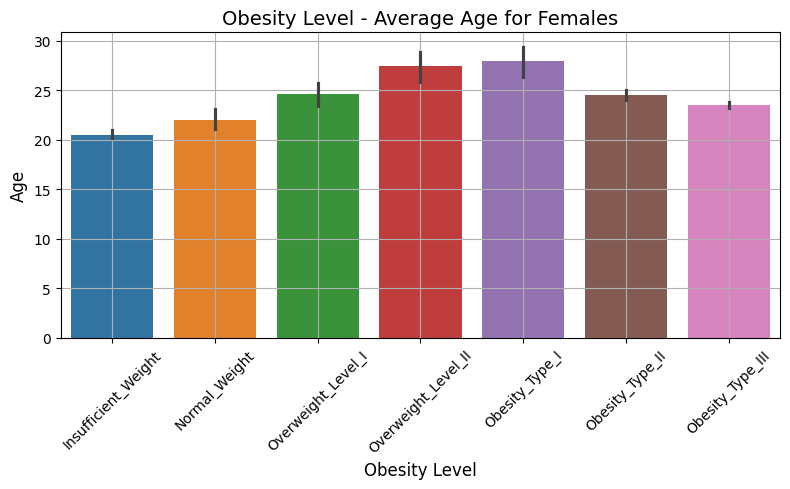

In [28]:
# Define figure
obesity_level_1 = plt.figure(figsize=(8,5))

# Obesity Level - Average age for females
obesity_level_1 = sns.barplot(data=dataset, x='NObeyesdad', y='Age',
                                     palette='tab10', order=obesity_order)
# Adjust X and Y-Axes
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 35, 5))
# Plot title and axes labels
plt.title('Obesity Level - Average Age for Females', fontsize=14)
plt.xlabel('Obesity Level', fontsize=12)
plt.ylabel('Age', fontsize=12)
# Plot grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

*NOTE: Black bar lines refer to a 95% confidence interval.

/tmp/ipython-input-1547551060.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  obesity_level_2 = sns.boxplot(data=dataset, x='NObeyesdad', y='Age',


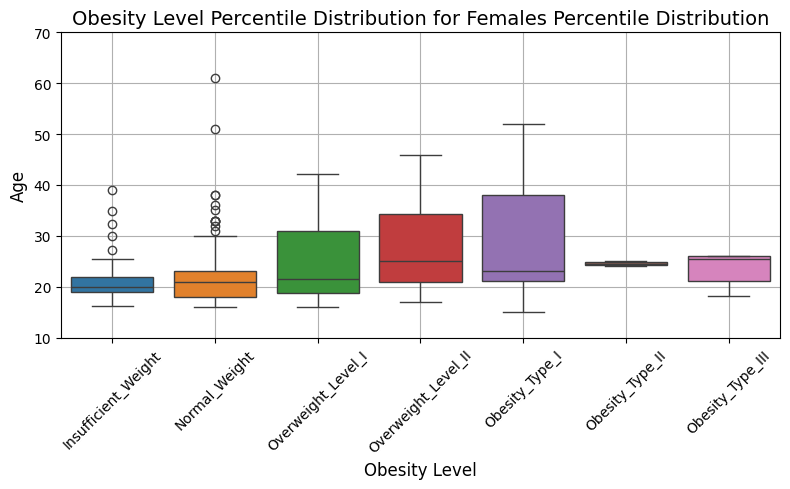

In [29]:
# Define figure
obesity_level_2 = plt.figure(figsize=(8,5))

# Obesity Level - average age for females - percentile distribution
obesity_level_2 = sns.boxplot(data=dataset, x='NObeyesdad', y='Age',
                                     palette='tab10', order=obesity_order)
# Adjust X and Y-Axes
plt.xticks(rotation=45)
plt.yticks(np.arange(10, 80, 10))
# Plot title and axes labels
plt.title('Obesity Level Percentile Distribution for Females Percentile Distribution', fontsize=14)
plt.xlabel('Obesity Level', fontsize=12)
plt.ylabel('Age', fontsize=12)
# Plot grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

/tmp/ipython-input-3428219955.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  obesity_level_female_violin = sns.violinplot(data=dataset, x='NObeyesdad',


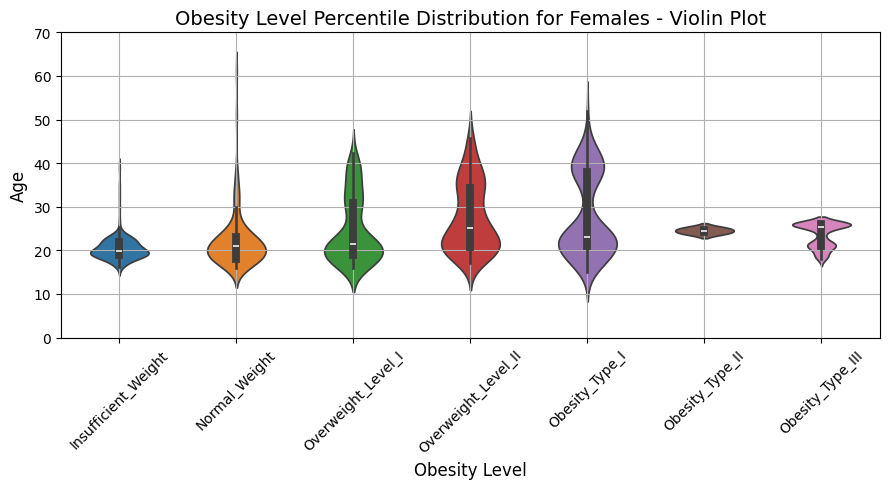

In [30]:
# Define figure
obesity_level_female_violin = plt.figure(figsize=(9,5))

# Obesity Level - average age for females - violin plot
obesity_level_female_violin = sns.violinplot(data=dataset, x='NObeyesdad',
                                             y='Age', width=0.5, palette='tab10',
                                             order=obesity_order)
# Adjust X and Y-Axes
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 80, 10))
# Plot title and axes labels
plt.title('Obesity Level Percentile Distribution for Females - Violin Plot', fontsize=14)
plt.xlabel('Obesity Level', fontsize=12)
plt.ylabel('Age', fontsize=12)
# Plot grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

In [31]:
# Perform a one-way ANOVA test for Obesity Level (dependent variable)

# One-way ANOVA test for each obesity level
f_stat, anova_p_value = f_oneway(dataset[dataset['NObeyesdad'] == 'Insufficient_Weight']['Age'],
                                dataset[dataset['NObeyesdad'] == 'Normal_Weight']['Age'],
                                dataset[dataset['NObeyesdad'] == 'Overweight_Level_I']['Age'],
                                dataset[dataset['NObeyesdad'] == 'Overweight_Level_II']['Age'],
                                dataset[dataset['NObeyesdad'] == 'Obesity_Type_I']['Age'],
                                dataset[dataset['NObeyesdad'] == 'Obesity_Type_II']['Age'],
                                dataset[dataset['NObeyesdad'] == 'Obesity_Type_III']['Age'],
                                equal_var=False
                                )
print("Null Hypothesis (H0)       : No significant difference in average age between obesity levels for females.")
print("Alternative Hypothesis (H1): There is a significant difference in average age between obesity levels for females.")
print("")

# Print and interpret results
print("f-value=%.3f, p-value=%.3f, significance level=%.2f" % (f_stat, anova_p_value, alpha))
if (anova_p_value < alpha):
    print('Reject Null Hypothesis (H0)')
else:
    print('Fail to Reject Null Hypothesis (H0)')

Null Hypothesis (H0)       : No significant difference in average age between obesity levels for females.
Alternative Hypothesis (H1): There is a significant difference in average age between obesity levels for females.

f-value=33.227, p-value=0.000, significance level=0.05
Reject Null Hypothesis (H0)


## 4. Prepare Data for Modelling

### 4.1. Select features

In [32]:
# Re-organize dataframe
df = dataset[[
              'Age',
              'Height',
              'Weight',
              'family_history_with_overweight',
              'FAVC',
              # 'FCVC',
              # 'NCP',
              'CAEC',
              # 'SMOKE',
              # 'CH2O',
              # 'SCC',
              # 'FAF',
              # 'TUE',
              'CALC',
              'MTRANS',
              'NObeyesdad'
            ]]

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1043 entries, 0 to 2110
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             1043 non-null   float64
 1   Height                          1043 non-null   float64
 2   Weight                          1043 non-null   float64
 3   family_history_with_overweight  1043 non-null   object 
 4   FAVC                            1043 non-null   object 
 5   CAEC                            1043 non-null   object 
 6   CALC                            1043 non-null   object 
 7   MTRANS                          1043 non-null   object 
 8   NObeyesdad                      1043 non-null   object 
dtypes: float64(3), object(6)
memory usage: 113.8+ KB


#### Select matrix of features (X) and dependent variable (y)

In [34]:
# Get values for matrix of features (X) and dependent variable (y)
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

print(X.shape, y.shape)

(1043, 8) (1043,)


#### 4.2. Label Encode categorical fields

In [35]:
# All features
le = LabelEncoder()
# le_columns = [0, 3, 4, 7, 8, 10, 13, 14]
le_columns = [3, 4, 5, 6, 7]

# Apply Label Encoding
for i in le_columns:
  X[:, i] = le.fit_transform(X[:, i])

# Label Encode the Dependent Variable
y = le.fit_transform(y)

# Print results
print(X[:, 0:14])
print(y)

[[21.0 1.62 64.0 ... 2 2 2]
 [21.0 1.52 56.0 ... 2 1 2]
 [23.0 1.5 55.0 ... 2 1 1]
 ...
 [22.524036 1.752206 133.689352 ... 2 1 2]
 [24.361936 1.73945 133.346641 ... 2 1 2]
 [23.664709 1.738836 133.472641 ... 2 1 2]]
[1 1 1 ... 4 4 4]


###### Dependent Variable Encoded Labels and Respective Classes:

0.   Insufficent Weight
1.   Normal Weight
2.   Obesity Type I
3.   Obesity Type II
4.   Obesity Type III
5.   Overweight Level I
6.   Overweight Level II

### 4.3. Split dataset into training and test sets

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(834, 8) (834,)
(209, 8) (209,)


### 4.4. Count number of records per dependent variable category

In [37]:
# Unique dependent variable labels (categories/classes)
set_y = np.unique(y_test)
set_y

array([0, 1, 2, 3, 4, 5, 6])

In [38]:
# Create Pandas dataframe for record counting
num_records = [[0, 'Insufficient_Weight'],
              [1, 'Normal_Weight'],
              [2, 'Obesity_Type_I'],
              [3, 'Obesity_Type_II'],
              [4, 'Obesity_Type_III'],
              [5, 'Overweight_I'],
              [6, 'Overweight_II']]
df_num_records = pd.DataFrame(num_records, columns=['Label', 'Category'])
# Count total number of records per category in test dataset (y_test)
y_test_records = dict(Counter(y_test).items())
y_test_records = dict(sorted(y_test_records.items()))

# Convert all observations to Pandas dataframe
df_num_records_values = pd.DataFrame(y_test_records.values(), columns=['Total'])
# Concatenate with records dataframe
df_num_records = pd.concat([df_num_records, df_num_records_values], axis=1)

df_num_records

,Label,Category,Total
0,0,Insufficient_Weight,35
1,1,Normal_Weight,22
2,2,Obesity_Type_I,30
3,3,Obesity_Type_II,1
4,4,Obesity_Type_III,69
5,5,Overweight_I,28
6,6,Overweight_II,24


### 4.5. Feature Scaling

In [39]:
# Perform Standardization (compute z-score)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 5. Build and Evaluate Machine Learning Models

In [40]:
# Logistic Regression (LR)
from sklearn.linear_model import LogisticRegression
# K-Nearest Neighbours (KNN)
from sklearn.neighbors import KNeighborsClassifier
# Support Vector Machine - Classification (SVC)
from sklearn.svm import SVC
# Decision Tree (DT)
from sklearn.tree import DecisionTreeClassifier
# Random Forest (RF)
from sklearn.ensemble import RandomForestClassifier
# XGBoost (XGB)
import xgboost as xgb
from xgboost import XGBClassifier
# LightGBM (LGB)
import lightgbm as lgb
from lightgbm import LGBMClassifier
# Deep Neural Network (DNN)
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Additional Libraries
import shap
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [41]:
# Plot confusion matrix
def plot_confusion_matrix(model, X_text=X_test, y_test=y_test):
  """
  model  - ML model, predicted results
  X_test - Matrix of features for test set
  y_test - Dependent (target) variable for test set
  """

  # Define confusion matrix figure
  cm = plt.figure(figsize=(7,7))

  # Plot the confusion matrix as heatmap
  cm = confusion_matrix(model, y_test)
  sns.heatmap(cm, annot=True)
  # Get number of predicted records per class (category)
  diag = cm.diagonal()
  # Plot title and axes labels
  plt.title('Confusion Matrix', fontsize=14)
  plt.xlabel('Actual Class', fontsize=12)
  plt.ylabel('Predicted Class', fontsize=12)

  # Return figure - to show
  return cm, diag

In [42]:
# Plot ROC curve
def plot_roc_curve(model, y_test, colour):
  """
  model  - Prediction model
  y_test - Dependent variable (test set)
  colour - Plot colour
  """

  # Define figure
  fig = plt.figure(figsize=(5,5))

  # fpr - False Positive Rate
  # tpr - True Positive Rate
  fpr, tpr, _ = roc_curve(y_test, model)
  # auc - Area Under Curve
  auc = roc_auc_score(y_test, model)
  fig = plt.plot(fpr, tpr, color=colour, label="FPR vs. TPR., AUC: " + str(auc))
  # Plot title and labels
  plt.xlabel("False Positive Rate (FPR)", fontsize=12)
  plt.ylabel("True Positive Rate (TPR)", fontsize=12)
  plt.title("ROC Curve", fontsize=14)
  # Plot legend and grid
  plt.legend(loc="lower right")
  plt.grid(True)

  return fig

In [43]:
# Apply k-Fold Cross Validation on the training set
def k_fold(model, n=10):
  """
  model - Machine Learning model implemented
  n     - number of k-Folds (default 10)
  """

  # Accuracy Scoring
  accuracy_means, accuracy_stds, accuracy_mins, accuracy_maxs = [], [], [], []
  # Cross validate for n k-folds (RepeatedStratifiedKFold - 3 repeats each)
  for i in range(2, 2+n):
    cv = RepeatedStratifiedKFold(n_splits=i, n_repeats=3, random_state=42)
    # Collect appropriate metric results per k-Fold
    accuracy_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

    # Force scores to be positive
    accuracy_scores = abs(accuracy_scores)

    # Append Accuracy scores
    accuracy_means.append(np.mean(accuracy_scores))
    accuracy_stds.append(np.std(accuracy_scores))
    accuracy_mins.append(np.min(accuracy_scores))
    accuracy_maxs.append(np.max(accuracy_scores))

  # Define subplot figure
  k_fold_results = plt.figure(figsize=(9, 4))
  k_fold_results.suptitle('k-Fold Cross Validation Results', fontsize=14)
  k_fold_results.supxlabel('k-Fold', fontsize=12)

  # Plot Accuracy scores per k-fold:
  ax1 = k_fold_results.add_subplot(1, 2, 1)
  ax1.plot(np.arange(1,1+n), accuracy_means, color='red')
  # Adjust X-Axis range
  plt.xticks(np.arange(0, 11, 1))
  # Plot title and label(s)
  ax1.set_ylabel('Accuracy ', fontsize=12)
  ax1.set_title('Accuracy per k-Fold', fontsize=14)
  # Plot grid
  ax1.grid(True)

  # Plot Accuracy Standard Deviations per k-fold:
  ax2 = k_fold_results.add_subplot(1, 2, 2)
  ax2.plot(np.arange(1,1+n), accuracy_stds, color='red')
  # Adjust X-Axis range
  plt.xticks(np.arange(0, 11, 1))
  # Plot title and label(s)
  ax2.set_ylabel('Standard Deviation', fontsize=12)
  ax2.set_title('Accuracy Standard Deviation per k-Fold', fontsize=14)
  # Plot grid
  ax2.grid(True)

  # Tight layout
  plt.tight_layout()

  # Show subplot
  plt.show()

  # Return cv for Grid Searching hyperparameter tuning (optimization)
  return cv

### 5.1. Machine Learning (ML) Models

*NOTE: In order to minimize script run-time

- All SHAP value results per model was commented out. Please refer to the README file for the most-relevant features.
- For each model (except KNN), the optimal hyperparameter values were already implemented.

#### 5.1.1. K-Nearest Neighbours (KNN)

In [44]:
# Start KNN model run time
knn_start_time = time.time()

In [45]:
# Identify optimal hyperparameters via GridSearch
knn_params = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=10)

In [46]:
# Define KNN model
# knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf = make_pipeline(knn_grid)

# Train KNN model
knn_clf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10]}))])

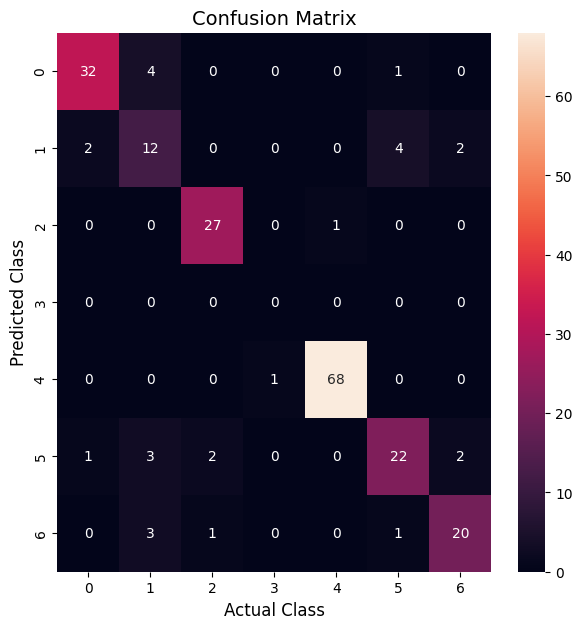


Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        35
           1       0.60      0.55      0.57        22
           2       0.96      0.90      0.93        30
           3       0.00      0.00      0.00         1
           4       0.99      0.99      0.99        69
           5       0.73      0.79      0.76        28
           6       0.80      0.83      0.82        24

    accuracy                           0.87       209
   macro avg       0.71      0.71      0.71       209
weighted avg       0.86      0.87      0.86       209



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
# Predict KNN results
knn_pred = knn_clf.predict(X_test)

# print('dt_pred: y_test:')
# print(np.concatenate((dt_pred.reshape(len(dt_pred), 1), y_test.reshape(len(y_test), 1)), 1 ))
# print('')

# Plot the confusion matrix
knn_cm, knn_records = plot_confusion_matrix(knn_pred, X_test, y_test)
plt.show()

# TP - True Positive
# TN - True Negative
# FP - False Positive (Type I Error)
# FN - False Negative (Type II Error)

# accuracy = (TP + TN)/(TN + FP + FN + TP)
# precision = TP/(TP + FP)
# recall = TP/(TP + FN)
# f1_score = (2 * precision * recall)/(precision + recall)
# support = Number of records of each class in predicted model

# Print Classification Report (brief summary of results)
print('')
print('Classification Report: ')
print(classification_report(y_test, knn_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea

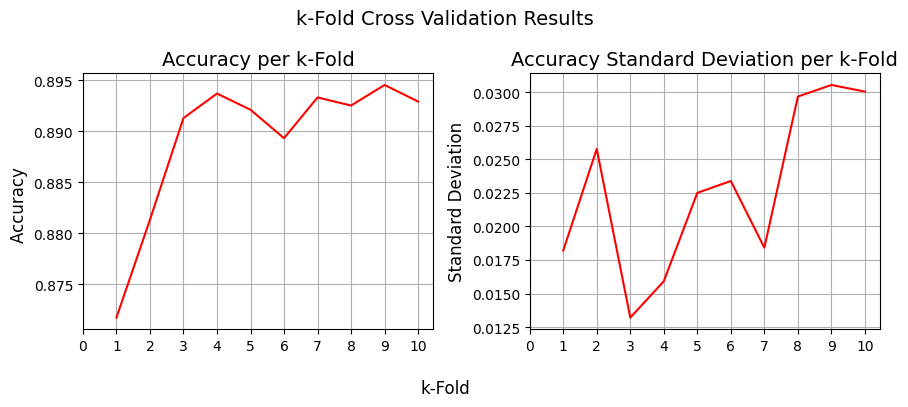

RepeatedStratifiedKFold(n_repeats=3, n_splits=11, random_state=42)

In [48]:
# Perform k-Fold Cross Validation
k_fold(knn_clf, 10)

In [49]:
# Count number of records in KNN predictions per category

# Add values to list
knn_records_list = pd.DataFrame(knn_records, columns=['KNN'])
# Concatenate with records dataframe
df_num_records = pd.concat([df_num_records, knn_records_list], axis=1)

df_num_records

,Label,Category,Total,KNN
0,0,Insufficient_Weight,35,32
1,1,Normal_Weight,22,12
2,2,Obesity_Type_I,30,27
3,3,Obesity_Type_II,1,0
4,4,Obesity_Type_III,69,68
5,5,Overweight_I,28,22
6,6,Overweight_II,24,20


In [50]:
# # KNN SHAP Value
# knn_explainer = shap.KernelExplainer(knn_clf.predict, shap.kmeans(X_train, 50))
# knn_shap_values = knn_explainer.shap_values(X_test)

# # Plot SHAP values per feature
# knn_shap_plot = shap.summary_plot(knn_shap_values, X_test)

# # Show plot
# plt.show()

Important Features:

- Overweight History, Food Between Meals, High-Caloric Foods, Alcohol Consumption, Age, Transportation Mode

In [51]:
# Calculate KNN model run time
knn_hours, knn_minutes, knn_seconds = run_time(knn_start_time)
print('KNN run time (h:mm:ss): ' + str(knn_hours) + ':' + str(knn_minutes) +
      ':' + str(knn_seconds))

KNN run time (h:mm:ss): 0:1:11


#### 5.1.2. Support Vector Machine - Classification (SVC)

In [52]:
# Start SVC model run time
svc_start_time = time.time()

In [53]:
# Identify optimal hyperparameters via GridSearch
svc_params = {'kernel': ['linear'],
              'C' : [100],
              # 'C' : [10, 100]
              }

svc_grid = GridSearchCV(SVC(), svc_params, cv=10)

In [54]:
# Define SVC model
svc_clf = SVC(kernel='linear', C=100)
# svc_clf = make_pipeline(svc_grid)

# Train SVC model
svc_clf.fit(X_train, y_train)

SVC(C=100, kernel='linear')

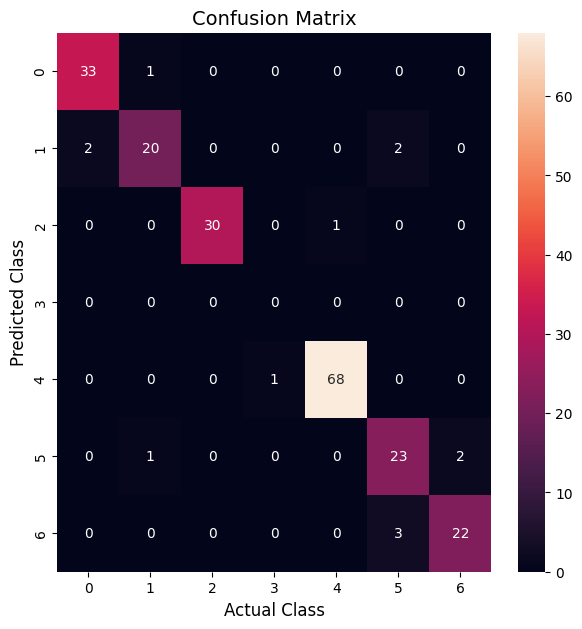


Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        35
           1       0.83      0.91      0.87        22
           2       0.97      1.00      0.98        30
           3       0.00      0.00      0.00         1
           4       0.99      0.99      0.99        69
           5       0.88      0.82      0.85        28
           6       0.88      0.92      0.90        24

    accuracy                           0.94       209
   macro avg       0.79      0.80      0.79       209
weighted avg       0.93      0.94      0.94       209



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [55]:
# Predict SVC results
svc_pred = svc_clf.predict(X_test)

# print('dt_pred: y_test:')
# print(np.concatenate((dt_pred.reshape(len(svc_pred), 1), y_test.reshape(len(y_test), 1)), 1 ))
# print('')

# Plot the confusion matrix
svc_cm, svc_records = plot_confusion_matrix(svc_pred, X_test, y_test)
plt.show()

# TP - True Positive
# TN - True Negative
# FP - False Positive (Type I Error)
# FN - False Negative (Type II Error)

# accuracy = (TP + TN)/(TN + FP + FN + TP)
# precision = TP/(TP + FP)
# recall = TP/(TP + FN)
# f1_score = (2 * precision * recall)/(precision + recall)
# support = Number of records of each class in predicted model

# Print Classification Report (brief summary of results)
print('')
print('Classification Report: ')
print(classification_report(y_test, svc_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea

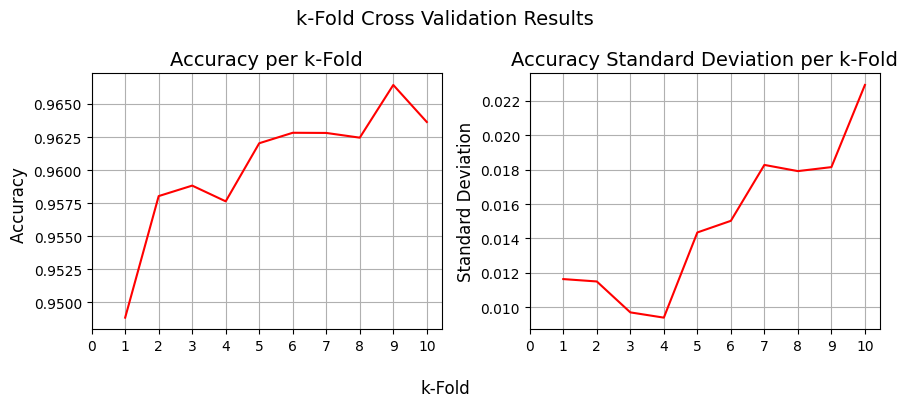

RepeatedStratifiedKFold(n_repeats=3, n_splits=11, random_state=42)

In [56]:
# Perform k-Fold Cross Validation
k_fold(svc_clf, 10)

In [57]:
# Count number of records in SVC predictions per category

# Add values to list
svc_records_list = pd.DataFrame(svc_records, columns=['SVC'])
# Concatenate with records dataframe
df_num_records = pd.concat([df_num_records, svc_records_list], axis=1)

df_num_records

,Label,Category,Total,KNN,SVC
0,0,Insufficient_Weight,35,32,33
1,1,Normal_Weight,22,12,20
2,2,Obesity_Type_I,30,27,30
3,3,Obesity_Type_II,1,0,0
4,4,Obesity_Type_III,69,68,68
5,5,Overweight_I,28,22,23
6,6,Overweight_II,24,20,22


In [58]:
# # SVC SHAP Values
# svc_shap_explainer = shap.KernelExplainer(svc_clf.predict, shap.kmeans(X_train, 50))
# svc_shap_values = svc_shap_explainer.shap_values(X_test)

# # Plot SHAP values per feature
# svc_shap_plot = shap.summary_plot(svc_shap_values, X_test)

# # Show plot
# plt.show()

Important Features:

- Weight, Height, Age, Vegetables in Meals, Transportation, Feed Between Meals, High-Caloric Foods

In [59]:
# Calculate SVC model run time
svc_hours, svc_minutes, svc_seconds = run_time(svc_start_time)
print('SVC run time (h:mm:ss): ' + str(svc_hours) + ':' + str(svc_minutes) +
      ':' + str(svc_seconds))

SVC run time (h:mm:ss): 0:0:11


#### 5.1.3. Random Forest (RF)

In [60]:
# Start RF model run time
rf_start_time = time.time()

In [61]:
# Identify optimal hyperparameters via GridSearch
rf_params = {'random_state': [42],
             'n_estimators': [100, 150, 200, 250],
             'max_depth': [2, 4, 6, 8, 10]}

rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=10)

In [62]:
# Define RF model
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
# rf_clf = make_pipeline(rf_grid)

# Train RF model
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

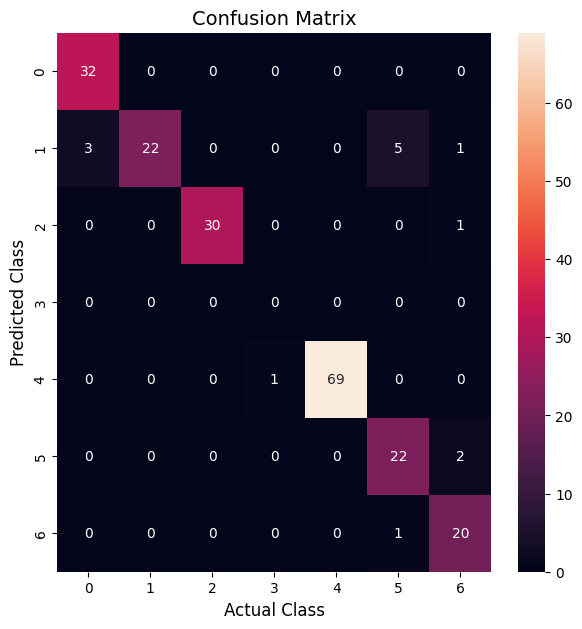


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.91      0.96        35
           1       0.71      1.00      0.83        22
           2       0.97      1.00      0.98        30
           3       0.00      0.00      0.00         1
           4       0.99      1.00      0.99        69
           5       0.92      0.79      0.85        28
           6       0.95      0.83      0.89        24

    accuracy                           0.93       209
   macro avg       0.79      0.79      0.79       209
weighted avg       0.94      0.93      0.93       209



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [63]:
# Predict RF results
rf_pred = rf_clf.predict(X_test)

# print('rf_pred: y_test:')
# print(np.concatenate((rf_pred.reshape(len(rf_pred), 1), y_test.reshape(len(y_test), 1)), 1 ))
# print('')

# Plot the confusion matrix
rf_cm, rf_records = plot_confusion_matrix(rf_pred, X_test, y_test)
plt.show()

# TP - True Positive
# TN - True Negative
# FP - False Positive (Type I Error)
# FN - False Negative (Type II Error)

# accuracy = (TP + TN)/(TN + FP + FN + TP)
# precision = TP/(TP + FP)
# recall = TP/(TP + FN)
# f1_score = (2 * precision * recall)/(precision + recall)
# support = Number of records of each class in predicted model

# Print Classification Report (brief summary of results)
print('')
print('Classification Report: ')
print(classification_report(y_test, rf_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea

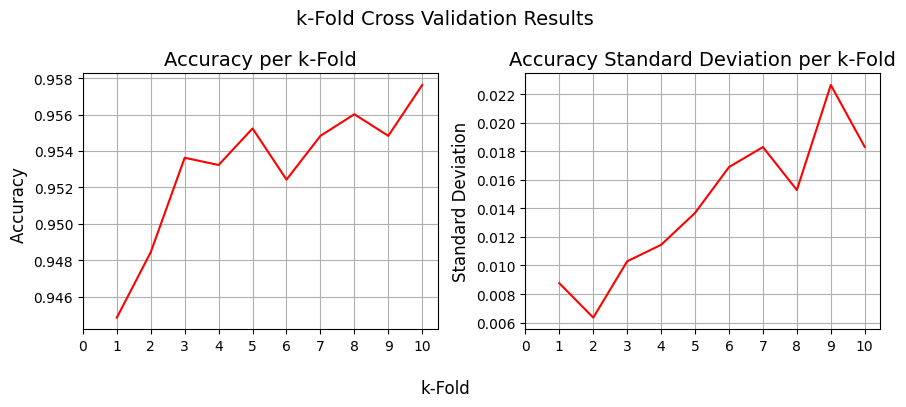

RepeatedStratifiedKFold(n_repeats=3, n_splits=11, random_state=42)

In [64]:
# Perform k-Fold Cross Validation
k_fold(rf_clf, 10)

In [65]:
# Count number of records in RF predictions per category

# Add values to list
rf_records_list = pd.DataFrame(rf_records, columns=['RF'])
# Concatenate with records dataframe
df_num_records = pd.concat([df_num_records, rf_records_list], axis=1)

df_num_records

,Label,Category,Total,KNN,SVC,RF
0,0,Insufficient_Weight,35,32,33,32
1,1,Normal_Weight,22,12,20,22
2,2,Obesity_Type_I,30,27,30,30
3,3,Obesity_Type_II,1,0,0,0
4,4,Obesity_Type_III,69,68,68,69
5,5,Overweight_I,28,22,23,22
6,6,Overweight_II,24,20,22,20


In [66]:
# # RF SHAP Values
# rf_shap_explainer = shap.KernelExplainer(rf_clf.predict, shap.kmeans(X_train, 50))
# rf_shap_values = rf_shap_explainer.shap_values(X_test)

# # Plot SHAP values per feature
# rf_shap_plot = shap.summary_plot(rf_shap_values, X_test)

# # Show plot
# plt.show()

Important Features:

- Weight, Height, Food Between Meals, Age, Overweight History, Alcohol Consumption, Time Spent on Tech Devices

In [67]:
# Calculate RF model run time
rf_hours, rf_minutes, rf_seconds = run_time(rf_start_time)
print('RF run time (h:mm:ss): ' + str(rf_hours) + ':' + str(rf_minutes) +
      ':' + str(rf_seconds))

RF run time (h:mm:ss): 0:0:39


### 5.2. Calculate Model Run-Times

In [68]:
print("Model Run-Times (h:mm:ss) and Accuracy results: \n")

# KNN
print('KNN - ' + str(knn_hours) + ':' + str(knn_minutes) + ':' + str(knn_seconds)
  + ", Accuracy: " + str(round(accuracy_score(y_test, knn_pred)*100, 2)) + "%")
# SVC
print('SVC - ' + str(svc_hours) + ':' + str(svc_minutes) + ':' + str(svc_seconds)
  + ", Accuracy: " + str(round(accuracy_score(y_test, svc_pred)*100, 2)) + "%")
# RF
print('RF - ' + str(rf_hours) + ':' + str(rf_minutes) + ':' + str(rf_seconds)
  + ", Accuracy: " + str(round(accuracy_score(y_test, rf_pred)*100, 2)) + "%")

Model Run-Times (h:mm:ss) and Accuracy results: 

KNN - 0:1:11, Accuracy: 86.6%
SVC - 0:0:11, Accuracy: 93.78%
RF - 0:0:39, Accuracy: 93.3%


### 5.3. Classification Results

In [69]:
# Results per each model
df_num_records

,Label,Category,Total,KNN,SVC,RF
0,0,Insufficient_Weight,35,32,33,32
1,1,Normal_Weight,22,12,20,22
2,2,Obesity_Type_I,30,27,30,30
3,3,Obesity_Type_II,1,0,0,0
4,4,Obesity_Type_III,69,68,68,69
5,5,Overweight_I,28,22,23,22
6,6,Overweight_II,24,20,22,20


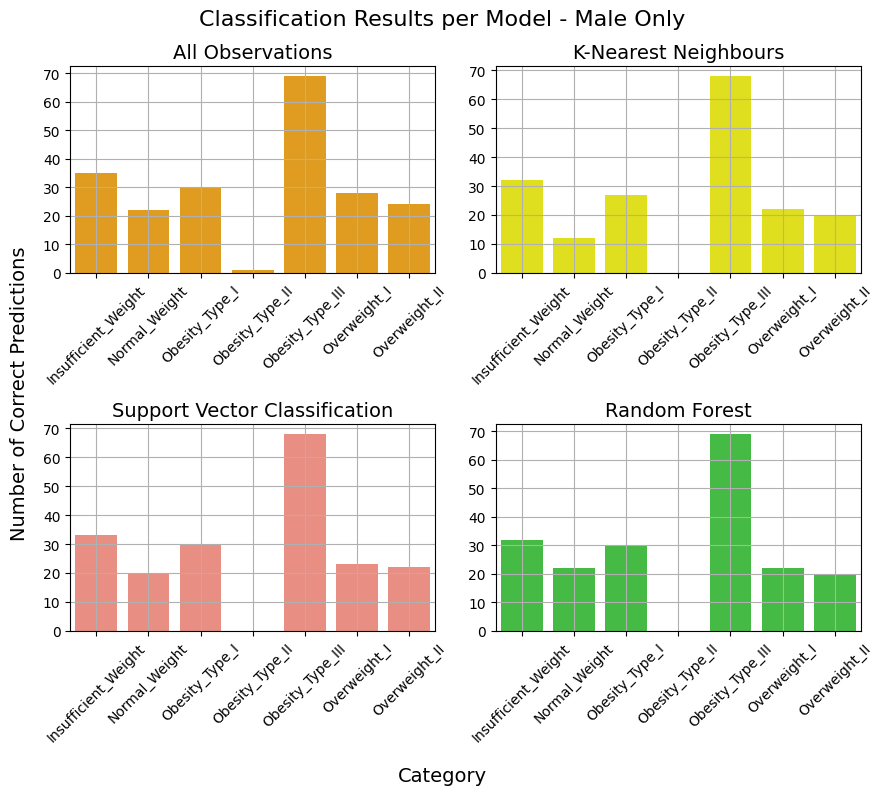

In [70]:
# Plot results
clf_model_results = plt.figure(figsize=(9, 8))

# Overall title and labels
clf_model_results.suptitle('Classification Results per Model - Male Only', fontsize=16)
clf_model_results.supxlabel('Category', fontsize=14)
clf_model_results.supylabel('Number of Correct Predictions', fontsize=14)

# All Categories
ax1 = clf_model_results.add_subplot(2, 2, 1)
ax1 = sns.barplot(data=df_num_records, x='Category', y='Total', color='orange')
# Adjust X-Axis labels
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 80, 10))
# Plot title and grid
plt.title("All Observations", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.grid(True)

# Correct predictions - KNN model
ax2 = clf_model_results.add_subplot(2, 2, 2)
ax2 = sns.barplot(data=df_num_records, x='Category', y='KNN', color='yellow')
# Adjust X-Axis labels
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 80, 10))
# Plot title and grid
plt.title("K-Nearest Neighbours", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.grid(True)

# Correct predictions - SVC model
ax3 = clf_model_results.add_subplot(2, 2, 3)
ax3 = sns.barplot(data=df_num_records, x='Category', y='SVC', color='salmon')
# Adjust X-Axis labels
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 80, 10))
# Plot title and grid
plt.title("Support Vector Classification", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.grid(True)

# Correct predictions - RF model
ax4 = clf_model_results.add_subplot(2, 2, 4)
ax4 = sns.barplot(data=df_num_records, x='Category', y='RF', color='limegreen')
# Adjust X-Axis labels
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 80, 10))
# Plot title and grid
plt.title("Random Forest", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.grid(True)

# Tight layout
plt.tight_layout()

plt.show()

### Calculate Script Run-Time

In [71]:
# Calculate script run time
script_hours, script_minutes, script_seconds = run_time(script_start_time)
print('Script run time (h:mm:ss): ' + str(script_hours) + ':' + str(script_minutes)
  + ':' + str(script_seconds))

Script run time (h:mm:ss): 0:2:48
